## Importing Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn.functional as F
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import time
import zipfile
import os
import h5py
from torchsummary import summary
from torchvision import transforms
from torch.utils import data
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
from sklearn.preprocessing import normalize
from torchvision import transforms, datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
import torch.nn as nn
import random

In [ ]:
zip_file_path = 'archive (3).zip'
extraction_dir = 'sales_dataset/'

os.makedirs(extraction_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

extracted_files = os.listdir(extraction_dir)
extracted_files


['Features data set.csv', 'sales data-set.csv', 'stores data-set.csv']

In [ ]:
features_df = pd.read_csv(f"{extraction_dir}Features data set.csv")
sales_df = pd.read_csv(f"{extraction_dir}sales data-set.csv")
stores_df = pd.read_csv(f"{extraction_dir}stores data-set.csv")

features_head = features_df.head()
sales_head = sales_df.head()
stores_head = stores_df.head()

(features_head, sales_head, stores_head)


(   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
 0      1  05/02/2010        42.31       2.572        NaN        NaN   
 1      1  12/02/2010        38.51       2.548        NaN        NaN   
 2      1  19/02/2010        39.93       2.514        NaN        NaN   
 3      1  26/02/2010        46.63       2.561        NaN        NaN   
 4      1  05/03/2010        46.50       2.625        NaN        NaN   
 
    MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
 0        NaN        NaN        NaN  211.096358         8.106      False  
 1        NaN        NaN        NaN  211.242170         8.106       True  
 2        NaN        NaN        NaN  211.289143         8.106      False  
 3        NaN        NaN        NaN  211.319643         8.106      False  
 4        NaN        NaN        NaN  211.350143         8.106      False  ,
    Store  Dept        Date  Weekly_Sales  IsHoliday
 0      1     1  05/02/2010      24924.50      False
 1      1

In [ ]:
#statistics for each dataset
features_stats = features_df.describe(include='all')
sales_stats = sales_df.describe(include='all')
stores_stats = stores_df.describe(include='all')

missing_values = {
    "features_df": features_df.isnull().sum(),
    "sales_df": sales_df.isnull().sum(),
    "stores_df": stores_df.isnull().sum()
}

(features_stats, sales_stats, stores_stats, missing_values)


(              Store        Date  Temperature   Fuel_Price      MarkDown1  \
 count   8190.000000        8190  8190.000000  8190.000000    4032.000000   
 unique          NaN         182          NaN          NaN            NaN   
 top             NaN  26/07/2013          NaN          NaN            NaN   
 freq            NaN          45          NaN          NaN            NaN   
 mean      23.000000         NaN    59.356198     3.405992    7032.371786   
 std       12.987966         NaN    18.678607     0.431337    9262.747448   
 min        1.000000         NaN    -7.290000     2.472000   -2781.450000   
 25%       12.000000         NaN    45.902500     3.041000    1577.532500   
 50%       23.000000         NaN    60.710000     3.513000    4743.580000   
 75%       34.000000         NaN    73.880000     3.743000    8923.310000   
 max       45.000000         NaN   101.950000     4.468000  103184.980000   
 
             MarkDown2      MarkDown3     MarkDown4      MarkDown5  \
 cou

In [ ]:
# Handling missing values in the features dataset
features_df.fillna({'MarkDown1': 0, 'MarkDown2': 0, 'MarkDown3': 0, 'MarkDown4': 0, 'MarkDown5': 0,
                    'CPI': features_df['CPI'].median(), 'Unemployment': features_df['Unemployment'].median()}, inplace=True)

sales_stores_df = pd.merge(sales_df, stores_df, on="Store")


features_df['Date'] = pd.to_datetime(features_df['Date'])
sales_stores_df['Date'] = pd.to_datetime(sales_stores_df['Date'])

full_dataset = pd.merge(sales_stores_df, features_df, on=["Store", "Date", "IsHoliday"])

full_dataset['Year'] = full_dataset['Date'].dt.year
full_dataset['Month'] = full_dataset['Date'].dt.month

full_dataset_info = full_dataset.info()
full_dataset_head = full_dataset.head()

(full_dataset_info, full_dataset_head)


<ipython-input-9-e489183f0f88>:11: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  features_df['Date'] = pd.to_datetime(features_df['Date'])
<ipython-input-9-e489183f0f88>:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  sales_stores_df['Date'] = pd.to_datetime(sales_stores_df['Date'])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     421570 non-null  float64       
 10  MarkDown2     421570 non-null  float64       
 11  MarkDown3     421570 non-null  float64       
 12  MarkDown4     421570 non-null  float64       
 13  MarkDown5     421570 non-null  float64       
 14  CPI           421570 non-null  float64       
 15  Unemployment  421

(None,
    Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  Temperature  \
 0      1     1 2010-05-02      24924.50      False    A  151315        42.31   
 1      1     2 2010-05-02      50605.27      False    A  151315        42.31   
 2      1     3 2010-05-02      13740.12      False    A  151315        42.31   
 3      1     4 2010-05-02      39954.04      False    A  151315        42.31   
 4      1     5 2010-05-02      32229.38      False    A  151315        42.31   
 
    Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
 0       2.572        0.0        0.0        0.0        0.0        0.0   
 1       2.572        0.0        0.0        0.0        0.0        0.0   
 2       2.572        0.0        0.0        0.0        0.0        0.0   
 3       2.572        0.0        0.0        0.0        0.0        0.0   
 4       2.572        0.0        0.0        0.0        0.0        0.0   
 
           CPI  Unemployment  Year  Month  
 0  211.096358       

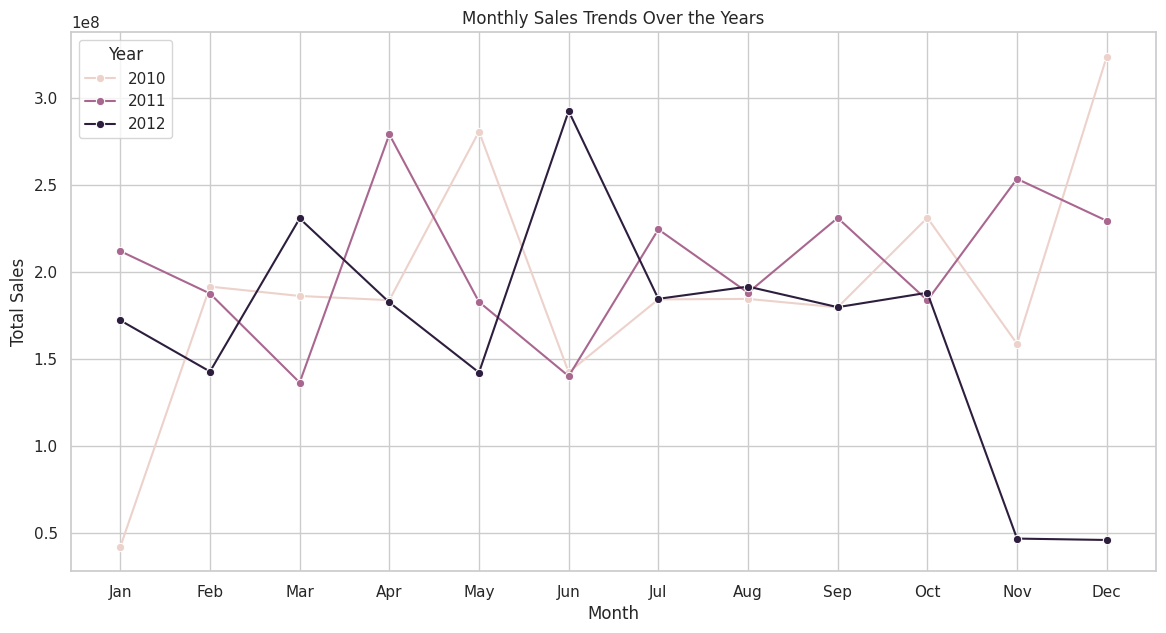

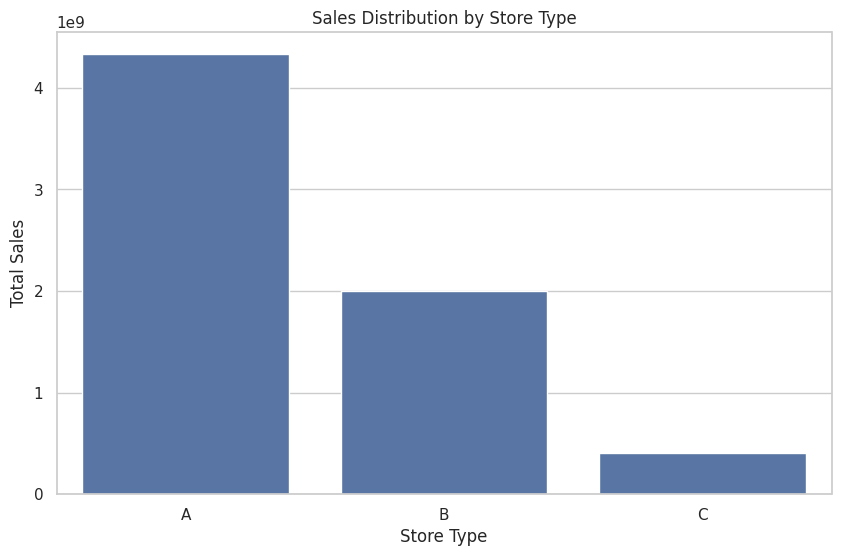

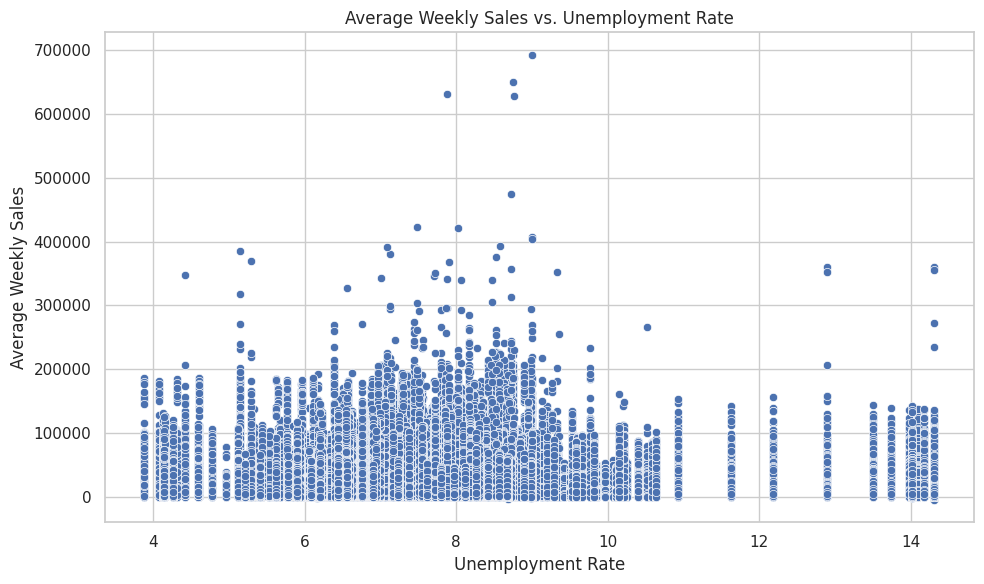

In [ ]:
sns.set(style="whitegrid")

# Visualization 1
plt.figure(figsize=(14, 7))
monthly_sales = full_dataset.groupby(['Year', 'Month'])['Weekly_Sales'].sum().reset_index()
sns.lineplot(x="Month", y="Weekly_Sales", hue="Year", data=monthly_sales, marker="o")
plt.title("Monthly Sales Trends Over the Years")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.legend(title='Year')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Visualization 2
plt.figure(figsize=(10, 6))
store_type_sales = full_dataset.groupby('Type')['Weekly_Sales'].sum().reset_index()
sns.barplot(x="Type", y="Weekly_Sales", data=store_type_sales)
plt.title("Sales Distribution by Store Type")
plt.xlabel("Store Type")
plt.ylabel("Total Sales")

# Visualization 3
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Unemployment", y="Weekly_Sales", data=full_dataset)
plt.title("Average Weekly Sales vs. Unemployment Rate")
plt.xlabel("Unemployment Rate")
plt.ylabel("Average Weekly Sales")

plt.tight_layout()
plt.show()


In [ ]:
full_dataset = full_dataset.drop(columns=['Date'])

full_dataset = full_dataset.sort_values(by=['Year', 'Month'])

cat_cols = ['Store', 'Dept', 'IsHoliday', 'Type', 'Year', 'Month']
num_cols = ['Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment','Weekly_Sales']

#onehot encoding
full_dataset = pd.get_dummies(full_dataset, columns=cat_cols)

# Normalization
scaler = StandardScaler()
full_dataset[num_cols] = scaler.fit_transform(full_dataset[num_cols])


In [ ]:
x_features = full_dataset.drop(columns=['Weekly_Sales']).values
y_labels = full_dataset['Weekly_Sales'].values

n = len(full_dataset)
train = int(n * 0.7)
val = int(n * 0.85)

X_train = x_features[:train]
y_train = y_labels[:train]
X_val = x_features[train:val]
y_val = y_labels[train:val]
X_test = x_features[val:]
y_test = y_labels[val:]

(X_train.shape, X_val.shape, X_test.shape), (y_train.shape, y_val.shape, y_test.shape)

(((295099, 156), (63235, 156), (63236, 156)), ((295099,), (63235,), (63236,)))

In [ ]:
train_loader = DataLoader(TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float()), shuffle=True, batch_size=64)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).float()), shuffle=False, batch_size=64)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float()), shuffle=False, batch_size=64)

In [ ]:

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=3):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        if x.dim() == 2:
          x = x.unsqueeze(1)
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train.shape[1]
hidden_size = 50
output_size = 1
model = RNNModel(input_size, hidden_size, output_size).to(device)
print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

RNNModel(
  (rnn): RNN(156, 50, num_layers=3, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        print('Epoch:', epoch+1, ' Train Loss:', train_losses[-1], ' Validation Loss:', val_losses[-1])

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


Epoch: 1  Train Loss: 0.22533527155681665  Validation Loss: 0.12287766165669756
Epoch: 2  Train Loss: 0.12350836342814248  Validation Loss: 0.10082293765645764
Epoch: 3  Train Loss: 0.09783372042162981  Validation Loss: 0.07935811878211187
Epoch: 4  Train Loss: 0.08000980744029695  Validation Loss: 0.06955068679272194
Epoch: 5  Train Loss: 0.07038478263294495  Validation Loss: 0.06863199271020622


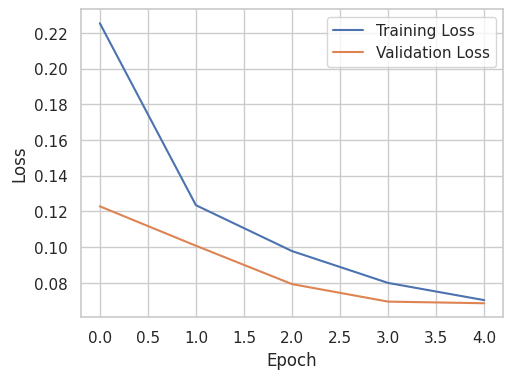

In [ ]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5)

In [ ]:
y_true=[]
y_pred=[]
with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          y_true.extend(labels.cpu().numpy())
          y_pred.extend(predicted.cpu().numpy())

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print("RMSE: ",rmse, "R^2: ", r2)

RMSE:  0.967523422647 R^2:  -0.00023381550278323004


In [ ]:
torch.save(model.state_dict(), 'model_part3.h5')

## References

1. https://arxiv.org/abs/1409.1556
2. https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
3. https://en.wikipedia.org/wiki/Early_stopping
4. https://pytorch.org/vision/stable/transforms.html
5. CSE 574 Machine Learning Assignment 2 submission by Dharma. Acha
6. https://pandas.pydata.org/
7. https://pytorch.org/vision/stable/models.html